**SYSTEM INFO**   
Tensorflow 2.12, CUDA 11.8.0, cudnn 8.6.0.163, Nvidia RTX 3080 Ti driver version 531.68, Windows 10 WSL2 & miniconda3

**IMPORTS**   
All needed packages:   
*tensorflow + keras*   
*numpy*   
*matplotlib*   
   
We set the memory growth - to reserve as much as needed, and not all at once.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.train import Checkpoint, CheckpointManager
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy import vstack
import numpy as np
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Input, Embedding, Dropout, Concatenate

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


**CONFIG**   
General algorithm training settings. Folder with the dataset, number of epochs, batch size and steps for saving preview images, checkpoints and the model itself.

In [2]:
data_dir = "/mnt/d/UG/inteligencja-obliczeniowa/data_CGAN/Train/Train/"
batch_size = 128
n_epochs = 10000
image_save_step = 10
model_save_step = 20
checkpoint_save_step = 5

**DATASET LOADING CONFIG**   
Here we configure our train_data which is an iterator. We set the target size of training data images, class mode (useful in conditional GAN) and color mode.

In [3]:
data_generator = ImageDataGenerator()
train_data = data_generator.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    subset='training'
)

Found 11125 images belonging to 2 classes.


**DISCRIMINATOR FOR CONDITIONAL GAN**   
Our discriminator is a bit more elaborate than the usual GAN. We've added a few layers to include classes. Here we have 394,085 trainable params.

In [19]:
def define_discriminator(d_optimizer, in_shape=(64, 64, 3), n_classes=2):
    # Image input
    in_image = Input(shape=in_shape)

    # Label input
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # Concatenate image and label
    merge = Concatenate()([in_image, li])

    # Convolutional layers
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    fe = Flatten()(fe)
    # więcej warst

    # Output
    out_layer = Dense(1, activation='sigmoid')(fe)

    # Define model
    model = Model([in_image, in_label], out_layer)

    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer=d_optimizer,
                  metrics=['accuracy'])

    return model

m = define_discriminator(Adam(lr=0.0002, beta_1=0.5))
m.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 50)        100         ['input_10[0][0]']               
                                                                                                  
 dense_8 (Dense)                (None, 1, 4096)      208896      ['embedding_4[0][0]']            
                                                                                                  
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                            

**LOADING AND PROCESSING DATA, GENERATING FAKE DATA**   
*generate_real_samples* - we take batch from our iterator as input, process these images and mark them with appropriate labels.   
*generate_latent_points* - This function is used to generate random data and appropriate labels that are later passed on to the generator to create images and appropriate labels.   
*generate_fake_samples* - This is where all the magic of generating images takes place depending on the given class.

In [6]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset  
	images = images.astype('float32') / 255.0
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y

# def generate_latent_points(latent_dim, n_samples):
#   return np.random.randn(n_samples, latent_dim)
def generate_latent_points(latent_dim, n_samples, n_classes=2):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]


def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y

**GENERATOR FOR CONDITIONAL GAN**   
As with the discriminator, the generator for conditional GAN is a bit more elaborate with additional layers that take into account classes. Our generator creates color images with dimensions of 64x64 px. It has 5,955,879 trainable params.

In [20]:
def define_generator(latent_dim, n_classes=2):
    # Label input
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 8 * 8
    li = Dense(n_nodes)(li)
    li = Reshape((8, 8, 1))(li)

    # Image generator input
    in_lat = Input(shape=(latent_dim,))
    n_nodes = 256 * 8 * 8
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 256))(gen)

    # Merge image generator and label input
    merge = Concatenate()([gen, li])

    # Upsample to 16x16
    gen = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Upsample to 32x32
    gen = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Upsample to 64x64
    gen = Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Output
    out_layer = Conv2D(3, (8, 8), activation='sigmoid', padding='same')(gen)

    # Define model
    model = Model([in_lat, in_label], out_layer)

    return model

latent_dim = 100
g_model = define_generator(latent_dim)
g_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 16384)        1654784     ['input_12[0][0]']               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 50)        100         ['input_11[0][0]']               
                                                                                            

**GENERATIVE ADVERSARIAL NETWORK**   
Here we combine the discriminator and generator into one model - GAN.

In [7]:
def define_gan(g_model, d_model, gan_optimizer):
    d_model.trainable = False
    
    # Connect generator and discriminator
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output

    gan_output = d_model([gen_output, gen_label])

    model = Model([gen_noise, gen_label], gan_output)

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=gan_optimizer)

    return model

**SAVE SAMPLE PLOT, SUMMARIZE PERFORMANCE**   
Auxiliary functions for saving image samples from a given epoch and calculating the discriminator's effectiveness.

In [8]:
def save_plot(examples, epoch, n=5):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake[0], epoch)

**TRAINING**   
The function that is the heart of our algorithm. We train our models by epoch: load a batch, train the discriminator and generator on it, and jump to the next batch. After exhausting all batches, we jump to the next epoch. At the same time, at the end of a predetermined epoch, we save preview images, model and checkpoints - the latter allow us to continue training after the algorithm has been interrupted from the last save.

In [9]:
def train(g_model, d_model, gan_model, train_data, latent_dim, n_epochs, n_batch, d_optimizer, gan_optimizer):
	bat_per_epo = len(train_data)
	half_batch = int(n_batch / 2)
	checkpoint_dir = '.'
	checkpoint = tf.train.Checkpoint(gan_optimizer=gan_optimizer,
				  discriminator_optimizer=d_optimizer,
					generator=g_model,
					discriminator=d_model,
					gan_model = gan_model)
	ckpt_manager = CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
	if ckpt_manager.latest_checkpoint:
		checkpoint.restore(ckpt_manager.latest_checkpoint)
		print ('Latest checkpoint restored!!')
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			dataset = next(train_data) #.astype('float32') / 255.0
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
		if (i + 1) % checkpoint_save_step == 0:
			ckpt_save_path = ckpt_manager.save()
			print ('Saving checkpoint for epoch {} at {}'.format(i+1,ckpt_save_path))	
		if (i+1) % image_save_step == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
		if (i+1) % model_save_step == 0:
			filename = 'generator_model_%03d.h5' % (i + 1)
			g_model.save(filename)

**ASSIGN VALUES AND START TRAINING**

In [11]:
latent_dim = 500
d_optimizer = Adam(lr=0.0002, beta_1=0.5)
gan_optimizer = Adam(lr=0.0002, beta_1=0.5)
d_model = define_discriminator(d_optimizer)
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model, gan_optimizer)

#train(g_model, d_model, gan_model, train_data , latent_dim, n_epochs, batch_size, d_optimizer, gan_optimizer)

**IMPORTS**   
nltk   
numpy   
matplotlib   
keras (tensorflow)   

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
#nltk.download('vader_lexicon')

**TEXT CLASSIFIER AND PLOT PRINTER**   
*classify_text* - this function uses the analyzer from the nltk.sentiment package, which checks whether the given text has a positive or negative connotation. Depending on this, we return the appropriate value.   
*show_plot* - auxiliary function displaying generated images.

In [8]:
def classify_text(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    if compound_score >= 0:
        return 0
    else:
        return 1
    
def show_plot(examples, x, y):
    for i in range(x * y):
        plt.subplot(y, x, i + 1)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

**GENERATOR**   
Takes model and text on input, classifies text and generates the appropriate pictures. In our case, if the text has a negative connotation, we generate male faces, otherwise - female ones.

In [4]:
def generate(model, text):
  #sentiment_label = classify_text(text)
  latent_points, labels = generate_latent_points(500, 4)
  #labels = np.full((4,), sentiment_label)
  labels = np.full((4,), 1)
  X = model.predict([latent_points, labels])
  show_plot(X, 2, 2)
  labels = np.full((4,), 0)
  X = model.predict([latent_points, labels])
  show_plot(X, 2, 2)

**LOAD MODEL AND CHECK HOW IT WORKS!**

1/1 [==============================] - 0s 131ms/step


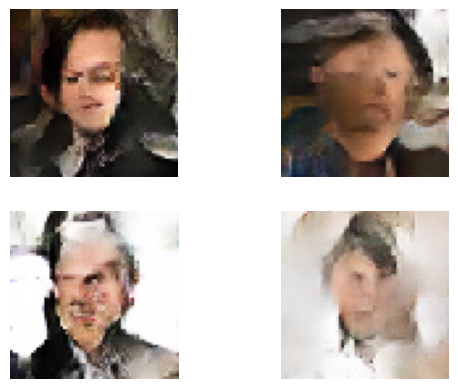

1/1 [==============================] - 0s 31ms/step


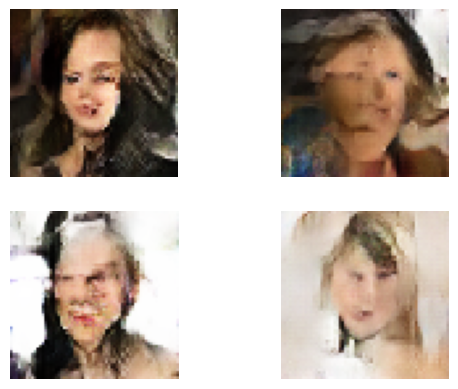

In [13]:
model = load_model('generator_model_160.h5', compile=False)

male = "This is an example text. Kill all people!"
female = "This is an example text. I am happy today!"
TEXT = female

generate(model, male)
#generate(model, female)